In [85]:
print("Test notebook connection")

Test notebook connection


In [86]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pytorch_lightning as pl
from torchvision import transforms, datasets
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import gradio as gr
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
TRAIN_MODELS_INSTEAD_OF_LOAD = False
DEPLOYMENT = True

In [88]:
!mkdir -p /app/checks
!touch /app/checks/gitkeep.txt

In [ ]:
if DEPLOYMENT == False:
    wandb.login()

True

# **1. Data acquisition**

The images are mostly from Pinterest or other image sharing platforms.


They were downloaded and uploaded to this repository manually, from where this code can access it

# **2. Data analysis**

In [90]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [91]:
bagel_images = load_images_from_folder('images/train/bagel')
burger_images = load_images_from_folder('images/train/burger')
sandwich_images = load_images_from_folder('images/train/sandwich')

In [92]:
len(bagel_images), len(burger_images), len(sandwich_images)

(50, 50, 50)

### Class distribution
We have 50 images of three classes.

The classes are:
- Bagel
- Burger
- Sandwich

The class distribution is equal since we have 50 images in all classes, so there are no class imbalances.



In [93]:
dataset_path = 'images/train'

### Visualizing samples

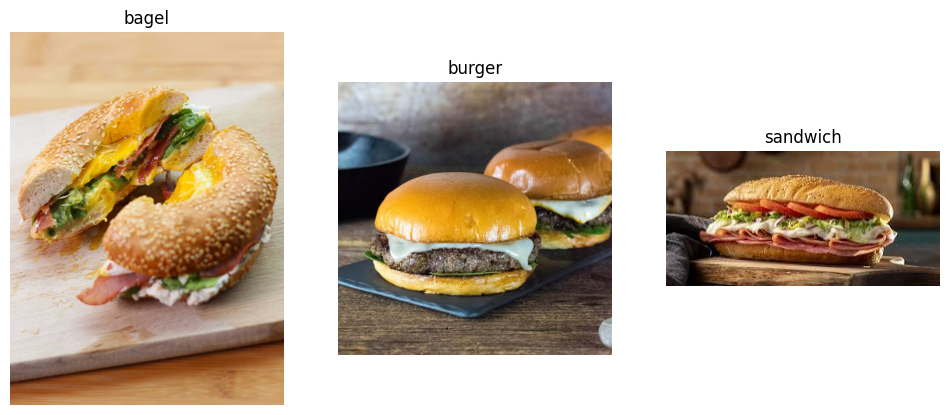

In [94]:
def analyze_dataset(dataset_path):
    class_samples = {}
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            image_files = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
            class_samples[class_name] = [os.path.join(class_path, img) for img in image_files[:5]]

    plt.figure(figsize=(12, 6))
    for idx, (class_name, samples) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), idx + 1)
        for img_path in samples:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.show()

analyze_dataset(dataset_path)

### Check image corruption

In [95]:
def check_image_corruption(dataset_path):
    corrupted_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path)
                        img.verify()
                    except Exception as e:
                        corrupted_images.append(img_path)
                        print(f"Corrupted image: {img_path}")

    if corrupted_images:
        print(f"Total corrupted images: {len(corrupted_images)}")
    else:
        print("No corrupted images found.")

check_image_corruption('images/train')
check_image_corruption('images/test')
check_image_corruption('images/val')

No corrupted images found.
No corrupted images found.
No corrupted images found.


### Statistical analysis

In [96]:
def calculate_image_statistics(dataset_path):
    widths, heights = [], []
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                    widths.append(img.width)
                    heights.append(img.height)
    
    if widths and heights:
        print(f"Average width: {np.mean(widths)}, Average height: {np.mean(heights)}")
    else:
        print("No valid images found.")

calculate_image_statistics('images/train')
calculate_image_statistics('images/val')


Average width: 582.9066666666666, Average height: 703.9866666666667
Average width: 1152.0, Average height: 896.0


# **3. Data cleansing and preparation**

In [97]:
class BurgerBagelSandwichDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, resolution=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.resolution = resolution
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=self.resolution, scale=(0.2, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.85, 1.15), shear=15),
            transforms.RandomRotation(degrees=20),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize(size=self.resolution, antialias=True),
            transforms.CenterCrop(size=self.resolution),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/train',
                transform=self.train_transform
            )

            self.val_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/val',
                transform=self.val_transform
            )

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/test',
                transform=self.val_transform
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [98]:
data_module = BurgerBagelSandwichDataModule(data_dir='images', batch_size=16, resolution=224, num_workers=1)
data_module.setup('fit')

class_names = data_module.train_dataset.classes
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [99]:
train_loader.dataset.classes, val_loader.dataset.classes

(['bagel', 'burger', 'sandwich'], ['bagel', 'burger', 'sandwich'])

# Phase 2

## Defining evaluation criteria 

- Accuracy: Ration of correctly predicted instances to the total instances
- Precision: Ratio of true positive predictions to the sum of true positives and false positives for each class
- Recall: Ratio of true positive predictions to the sum of true positives and false negatives for each class
- F1 Score: The harmonic mean of precision and recall. It provides a balance between the two metrics
- Confusion Matrix: A matrix that shows the number of correct and incorrect predictions broken down by class

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, dataloader, classes, logger=None):
    model = model.to(device)
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if logger:
        logger.experiment.log({
            "test_accuracy": accuracy,
            "test_precision": precision,
            "test_recall": recall,
            "test_f1_score": f1
        })
        
        if torch.cuda.is_available():
            logger.experiment.log({
                "gpu_memory_allocated (MB)": torch.cuda.memory_allocated(device) / (1024 ** 2)
            })
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")

    cm_image_path = "confusion_matrix.png"
    plt.savefig(cm_image_path)

    if logger:
        logger.experiment.log({"Confusion Matrix": wandb.Image(cm_image_path)})
        
    plt.show()

## Baseline Model

### Define hyperparams

In [101]:
learning_rate = 1e-4
max_epochs = 100
dropout_rate = 0.3
weight_decay = 1e-4

### Define baseline model

In [102]:
class BaselineModel(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(BaselineModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 112 * 112, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters()


    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return [optimizer], [scheduler]

In [103]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checks/',
    filename='best_baseline_model',
    save_top_k=1,
    mode='min'
)

In [104]:
best_baseline_model_path = '/app/checks/best_baseline_model.ckpt'

trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[checkpoint_callback])

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    baseline_model = BaselineModel(num_classes=3)
    trainer.fit(baseline_model, data_module)
else:   
    if os.path.exists(best_baseline_model_path):
        print("It does exist!")
        baseline_model = BaselineModel.load_from_checkpoint(best_baseline_model_path)
        baseline_model.eval()
    else:
        print("It does not exist!")
        baseline_model = BaselineModel(num_classes=3)
        trainer.fit(baseline_model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


It does not exist!


/usr/local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /app/checks exists and is not empty.

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | conv_layer | Sequential       | 448    | train
1 | fc_layer   | Sequential       | 25.7 M | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.764   Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.071805477142334     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.3333
Precision: 0.1111
Recall: 0.3333
F1 Score: 0.1667


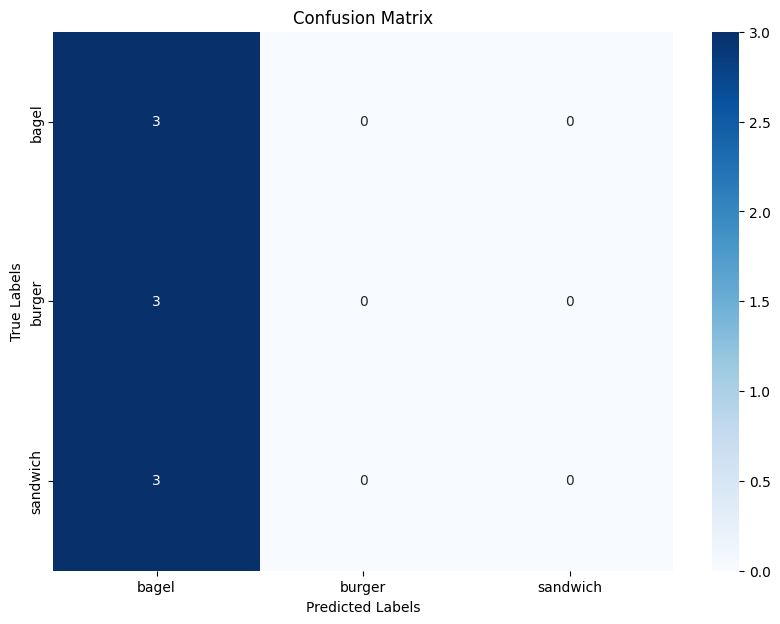

In [105]:
trainer.test(baseline_model, data_module)
evaluate_model(baseline_model, data_module.test_dataloader(), class_names)

## Incremental model development

### Add complexity

In [106]:
class ComplexModel(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(ComplexModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return [optimizer], [scheduler]

In [107]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checks/',
    filename='best_complex_model',
    save_top_k=1,
    mode='min'
)

In [108]:
best_complex_model_path = '/app/checks/best_complex_model.ckpt'

trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[checkpoint_callback])

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    complex_model = ComplexModel(num_classes=3)
    trainer.fit(baseline_model, data_module)
else:   
    if os.path.exists(best_complex_model_path):
        print("It does exist!")
        complex_model = ComplexModel.load_from_checkpoint(best_complex_model_path)
        complex_model.eval()
    else:
        print("It does not exist!")
        complex_model = ComplexModel(num_classes=3)
        trainer.fit(complex_model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


It does not exist!


/usr/local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /app/checks exists and is not empty.

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 19.4 K | train
1 | fc_layers   | Sequential       | 25.7 M | train
2 | criterion   | CrossEntropyLoss | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.840   Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.1098947525024414     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.3333
Precision: 0.1111
Recall: 0.3333
F1 Score: 0.1667


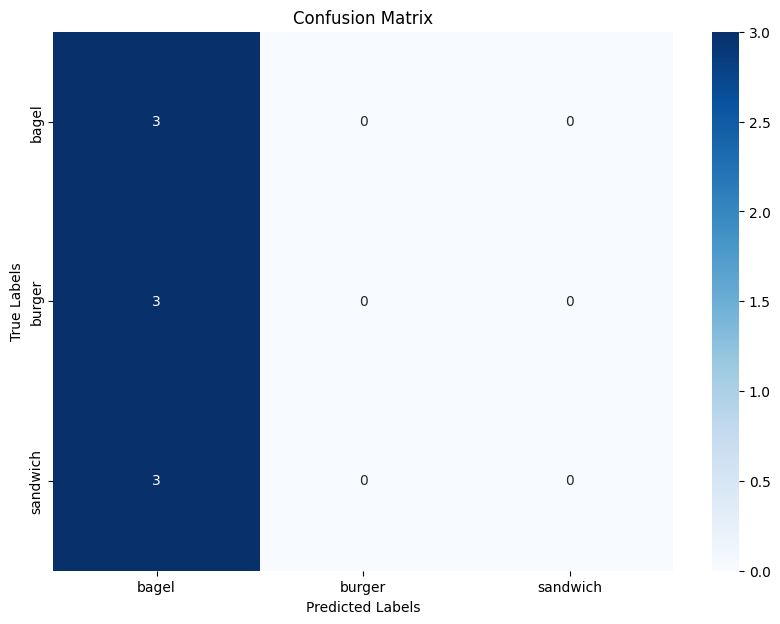

In [109]:
trainer.test(complex_model, data_module)

evaluate_model(complex_model, data_module.test_dataloader(), class_names)

### Use transfer learning

In [110]:
class TransferLearningModel(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(TransferLearningModel, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return [optimizer], [scheduler]

In [111]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checks/',
    filename='best_transfer_model',
    save_top_k=1,
    mode='min'
)

In [112]:
best_transfer_model_path = '/app/checks/best_transfer_model.ckpt'

trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[checkpoint_callback])

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    transfer_model = TransferLearningModel(num_classes=3)
    trainer.fit(transfer_model, data_module)
else:   
    if os.path.exists(best_transfer_model_path):
        print("It does exist!")
        transfer_model = TransferLearningModel.load_from_checkpoint(best_transfer_model_path)
        transfer_model.eval()
    else:
        print("It does not exist!")
        transfer_model = TransferLearningModel(num_classes=3)
        trainer.fit(transfer_model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


It does not exist!


/usr/local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /app/checks exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.12470921874046326    │
└───────────────────────────┴───────────────────────────┘

Accuracy: 0.8889
Precision: 0.9167
Recall: 0.8889
F1 Score: 0.8857


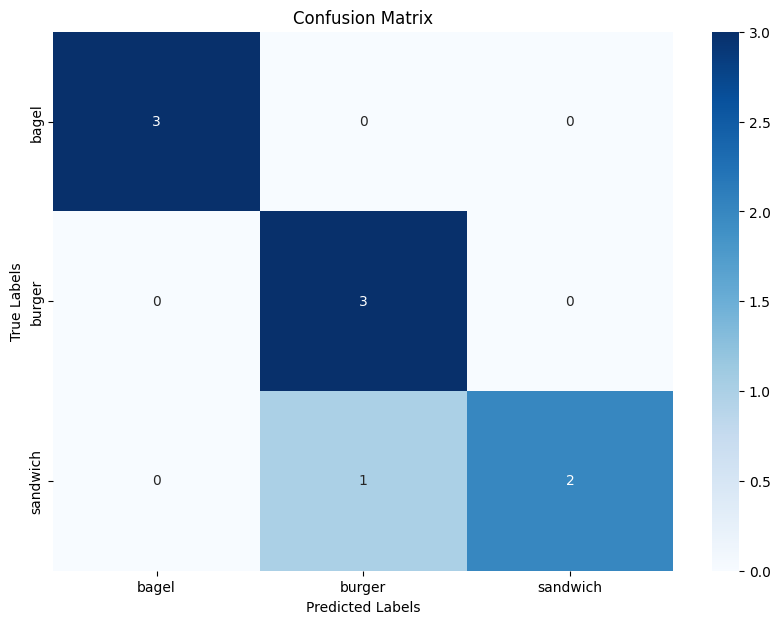

In [113]:
trainer.test(transfer_model, data_module)

evaluate_model(transfer_model, data_module.test_dataloader(), class_names)

### Ensemble models

In [114]:
class EnsembleModel(pl.LightningModule):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters(ignore=["models"])

        for model in self.models:
            if len(list(model.parameters())) == 0:
                print(f"Model {model.__class__.__name__} has no parameters.")

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        acc = (torch.argmax(outputs, dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        acc = (torch.argmax(outputs, dim=1) == y).float().mean()
        self.log('test_acc', acc)

    def configure_optimizers(self):
        params = [p for model in self.models for p in model.parameters()]
        
        if not params:
            raise ValueError("No parameters found for optimization.")

        optimizer = torch.optim.Adam(
            params, 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return [optimizer], [scheduler]
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self(x)
            predictions = torch.argmax(outputs, dim=1)
        return predictions

### Set up wandb and logging

In [115]:
wandb_logger = pl.loggers.WandbLogger(project='food-classification-homework', log_model="all")
early_stopping_callback = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    mode="min"
)

In [116]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checks/',
    filename='best_ensemble_model',
    save_top_k=1,
    mode='min'
)

In [ ]:
best_ensemble_model_path = '/app/checks/best_ensemble_model.ckpt'

if DEPLOYMENT == False:
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        logger=wandb_logger,
        callbacks=[early_stopping_callback, checkpoint_callback]
    )
else:
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[early_stopping_callback, checkpoint_callback]
    )

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    ensemble = EnsembleModel(models=[baseline_model, complex_model, transfer_model])
    trainer.fit(ensemble, data_module)
else:   
    if os.path.exists(best_ensemble_model_path):
        print("It does exist!")
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            callbacks=[early_stopping_callback, checkpoint_callback]
        )
        ensemble = EnsembleModel.load_from_checkpoint(best_ensemble_model_path, models=[baseline_model, complex_model, transfer_model])
        ensemble.eval()
    else:
        print("It does not exist!")
        ensemble = EnsembleModel(models=[baseline_model, complex_model, transfer_model])
        trainer.fit(ensemble, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


It does not exist!


/usr/local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /app/checks exists and is not empty.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4444444477558136     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.4444
Precision: 0.4583
Recall: 0.4444
F1 Score: 0.3485


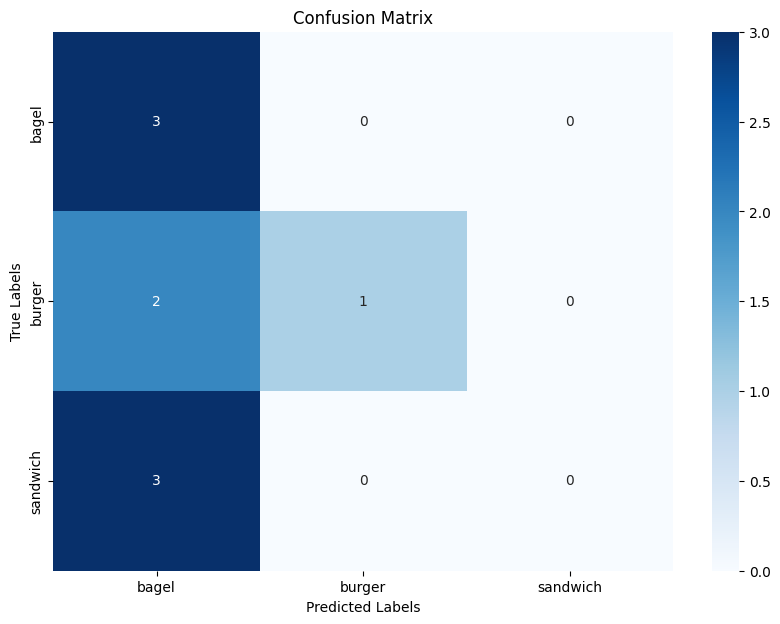

In [ ]:
trainer.test(ensemble, data_module)

if DEPLOYMENT == False:
    evaluate_model(ensemble, data_module.test_dataloader(), class_names, logger=wandb_logger)

### Load up the best model from the run

In [122]:
""" best_model_path = checkpoint_callback.best_model_path
best_model = EnsembleModel.load_from_checkpoint(best_model_path, models=[baseline_model, complex_model, transfer_model])

evaluate_model(best_model, data_module.test_dataloader(), class_names, logger=wandb_logger) """
best_model = ensemble

In [ ]:
## Run this if you interrupted the run

if DEPLOYMENT == False:
    wandb.finish()

epoch,▁▂▃▄▅▆▆▇█
test_acc,▁
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,▁
trainer/global_step,▁▂▃▄▆▆▇████
val_acc,▂█▂▁▆▅▂
val_loss,▃▁▇█▃▂▃
epoch,7


### Define some helper functions

In [123]:
def preprocess_image(image_path, resolution=224):
    preprocess = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    return img_tensor

def predict_image(model, image_path):
    model.to(device)
    model.eval()

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        output = model(img_tensor)
    
    predicted_class_index = torch.argmax(output, dim=1).item()
    predicted_class_name = class_names[predicted_class_index]

    print(f'The predicted class for the image is: {predicted_class_name}')

### Make a prediction on a test bagel image

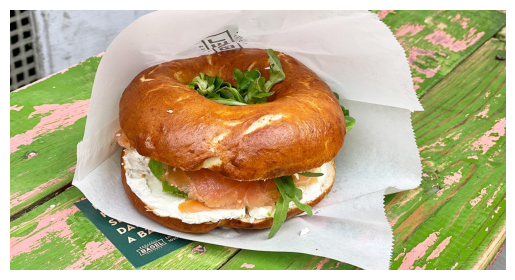

The predicted class for the image is: bagel


In [124]:
image_path = './images/test/bagel/test_1.jpg'
predict_image(best_model, image_path)


### Make a prediction on a test burger image

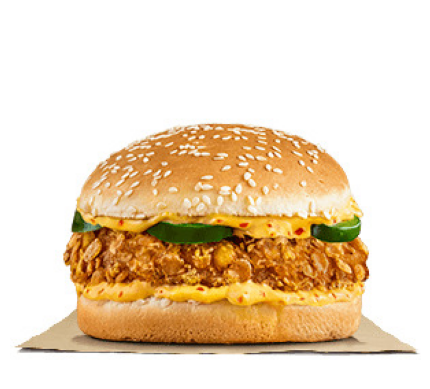

The predicted class for the image is: burger


In [125]:
image_path_2 = './images/test/burger/test_5.jpg'
predict_image(best_model, image_path_2)

### Make a prediction on a test sandwich image

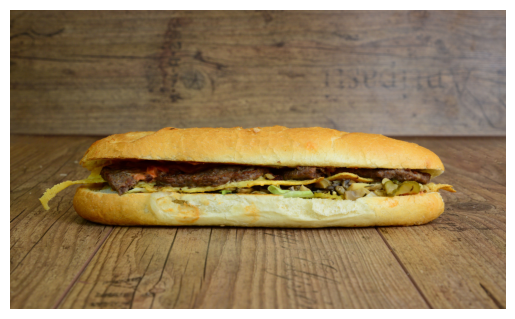

The predicted class for the image is: sandwich


In [126]:
image_path_2 = './images/test/sandwich/test_3.jpg'
predict_image(best_model, image_path_2)

# Milestone 3

## Create the UI and service

Add preprocesser function for prediction

In [127]:
def preprocess_image(image, resolution=224):
    preprocess = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    return img_tensor

Add predict function that returns the predicted label of the input image with the input model

In [ ]:
def predict_image(model, image_path):
    model.to(device)
    model.eval()

    if isinstance(image_path, str):
        img = Image.open(image_path)
    else:
        img = Image.fromarray(image_path)

    img_tensor = preprocess_image(img)

    with torch.no_grad():
        output = model(img_tensor.to(device))

    predicted_class_index = torch.argmax(output, dim=1).item()

    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

Define cleanup, so when the container stops, the server closes

In [ ]:
import signal
import logging

def cleanup():
    logging.info("Shutting down the server")
    gr.close_all()

signal.signal(signal.SIGTERM, cleanup)

Make the gradio UI and server

In [ ]:
history = []

def predict(image):
    label = predict_image(transfer_model, image)
    
    history.append((image, label))
    
    return history

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="filepath", label="Input Image"),
    outputs=gr.Gallery(label="Processed Images"),
)

logging.info("Starting the server at http://localhost:7860")
server = demo.launch(server_port=7860, debug=True)

In [130]:
## Run this if you want to close the running servers
gr.close_all()

Closing server running on port: 7860
